In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from sklearn.model_selection import GridSearchCV

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing

import numpy as np
import pandas as pd

import warnings
warnings.simplefilter("ignore")

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import BaggingRegressor
from xgboost.sklearn import XGBRegressor

from sklearn.metrics import mean_squared_error 

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'1xZ8DlAKXvVg7gqUdzYYLdj6vhW8oXz1b' in parents"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))


#We should now load the data into the local storage of google colab
download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

Items_file = os.path.join(download_path, 'items-translated.csv')
Items = drive.CreateFile({'id': '1E6KLN1jn4MOvw_yQJ57vFKIMCQduO8Ar'})
Items.GetContentFile(Items_file)

Shops_file = os.path.join(download_path, 'shops-translated.csv')
Shops = drive.CreateFile({'id': '1WxOC0lTqlaVbVU41rxGBUaoSB4RZYade'})
Shops.GetContentFile(Shops_file)

itemsCategories_file = os.path.join(download_path, 'item_categories-translated.csv')
Item_categories = drive.CreateFile({'id': '1GZfjwZU7HaEYOQc4gQDvHXlFJ3veLWDS'})
Item_categories.GetContentFile(itemsCategories_file)

train_file = os.path.join(download_path, 'sales_train.csv')
train = drive.CreateFile({'id': '10NhafWdA-9EAVPdBKeOrhPZYGGleV0Ph'})
train.GetContentFile(train_file)

test_file = os.path.join(download_path, 'test.csv')
test = drive.CreateFile({'id': '1P43-5PZtxCO1kwOt2-xlGpq0cKQ-mPYu'})
test.GetContentFile(test_file)
#We can now load the data into pandas



#We have tried importing files from local machine also
#import pandas as pd
#item_data = pd.read_csv("C:\\Users\\chitt\\Desktop\\Final Datasets\\items-translated.csv")
#shops_data = pd.read_csv("C:\\Users\\chitt\\Desktop\\Final Datasets\\shops-translated.csv")
#item_categories_data = pd.read_csv("C:\\Users\\chitt\\Desktop\\Final Datasets\\item_categories-translated.csv")
#train_data = pd.read_csv("C:\\Users\\chitt\\Desktop\\Final Datasets\\sales_train.csv")
#test_data = pd.read_csv("C:\\Users\\chitt\\Desktop\\Final Datasets\\test.csv")


#print(item_data.head())
#print(shops_data.head())
#print(item_categories_data.head())
#print(train_data.head())
#print(test_data.head())



title: items-translated.csv, id: 1E6KLN1jn4MOvw_yQJ57vFKIMCQduO8Ar
title: test.csv, id: 1P43-5PZtxCO1kwOt2-xlGpq0cKQ-mPYu
title: sales_train.csv, id: 10NhafWdA-9EAVPdBKeOrhPZYGGleV0Ph
title: sample_submission.csv, id: 1MpHGZSV80WrHljQvJOGzhTJJ5GdFUZlH
title: shops-translated.csv, id: 1WxOC0lTqlaVbVU41rxGBUaoSB4RZYade
title: item_categories-translated.csv, id: 1GZfjwZU7HaEYOQc4gQDvHXlFJ3veLWDS


In [0]:

items_data = pd.read_csv(Items_file)
items_data.head()

,item_name_translated,item_id,item_category_id
0,!! IN THE POWER OF HAPPINESS (PLAST) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** IN THE GLORY OF THE GLORY (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40


In [0]:
item_categories_data = pd.read_csv(itemsCategories_file)
item_categories_data.head()

,item_category_id,item_category_name_translated
0,0,PC - Headsets / Headphones
1,1,Accessories - PS2
2,2,Accessories - PS3
3,3,Accessories - PS4
4,4,Accessories - PSP


In [0]:
shops_data = pd.read_csv(Shops_file)
shops_data.head()

,shop_id,shop_name_translated
0,0,"Yakutsk Ordzhonikidze, 56 francs"
1,1,"Yakutsk TC ""Central"" franc"
2,2,"Adygea Shopping Center ""Mega"""
3,3,"Balashikha TRK ""October-Kinomir"""
4,4,"Volzhsky shopping center ""Volga Mall"""


In [0]:
train_data = pd.read_csv(train_file)
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [0]:
test_data = pd.read_csv(test_file)
test_data.head()

,id,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [0]:
#function to handle duplicate records
def drop_duplicate(set, data):
    b = data.shape[0]
    data.drop_duplicates(set, inplace=True, keep='last')
    data.reset_index(inplace=True, drop=True)
    a = data.shape[0]
    duplicateCount = b-a
    print('No of Duplicate records:', duplicateCount)

In [0]:
#function to handle absurd data records
def handlingAbsurdData(train_data):
  data = train_data[train_data.item_price < 0]
  length = len(data)
  
  #replacing the -ve values with mean of modes of the +ve values for the respective key
  for i in range(length):
    meanofModes = train_data[(train_data.shop_id==data.iloc[i , 2])&(train_data.item_id==data.iloc[i , 3])&(train_data.date_block_num==data.iloc[i , 1])&(train_data.item_price>0)].item_price.mode().mean()
    train_data.loc[(train_data.shop_id==data.iloc[i , 2])&(train_data.item_id==data.iloc[i , 3])&(train_data.date_block_num==data.iloc[i , 1])&(train_data.item_price<0), 'item_price'] = meanofModes
 

In [0]:
#function to handle outliers 
def removingOutliers(train_data):
  plt.figure(figsize=(11,5))
  plt.xlim(train_data.item_cnt_day.min(), train_data.item_cnt_day.max()*1.5)
  sb.boxplot(x=train_data.item_cnt_day)

  plt.figure(figsize=(11,5))
  plt.xlim(train_data.item_price.min(), train_data.item_price.max()*1.5)
  sb.boxplot(x=train_data.item_price)
  
  train_data = train_data[train_data.item_price<=300000]
  train_data = train_data[train_data.item_cnt_day<=2000]
  

In [0]:
# adding categories column to the item_categories_data
def cluster_categories(item_categories_data):
  string_categories  = item_categories_data["item_category_name_translated"];
  words = []
  keywords = []
  count=0
  for i in string_categories:
    words = i.split("-")
    keywords.append(words[0])
  string_categories = keywords
  #for i in keywords:
  #  count+=1
  #  print(str(count) + " " + i);

  set_keywords = set(keywords)
  print(set_keywords)
  count = 0;
  my_dictionary_of_words = {}
  for i in set_keywords:
    my_dictionary_of_words[i] = count
    count+=1

  print(my_dictionary_of_words)
  frequency = []
  for i in string_categories:
    frequency.append(my_dictionary_of_words.get(i))

  item_categories_data["categories_clustered"] = frequency
  item_categories_data.set_value(25, 'categories_clustered', 23) #Game accessories would be different from the rest.

In [0]:
# merging categories column to the items dataframe using item_category_id as foreign key
def appendingCategoriesColumn(items_data, item_categories_data):
  pivot_df = train_data.pivot_table(index=['item_id', 'shop_id'], aggfunc='sum', values='item_cnt_day', columns='date_block_num').fillna(0.0)
  #print(pivot_df)
  
  train_filtered = pivot_df.reset_index()

  item_categoriesAppended = items_data.merge(item_categories_data[['categories_clustered','item_category_id']], on="item_category_id", how="inner")[['item_id','categories_clustered']]

  train_filtered = train_filtered.merge(item_categoriesAppended, on="item_id", how="inner")

  number = preprocessing.LabelEncoder()
  train_filtered[['categories_clustered']] = number.fit_transform(train_filtered.categories_clustered)

  train_filtered = train_filtered[['categories_clustered'] + ['shop_id', 'item_id'] + list(range(34))]
  
  return train_filtered


In [0]:
# function to handle data preprocessing of the data
def dataPreprocessing():
  train_data['date'] = pd.to_datetime(train_data.date, format="%d.%m.%Y")
  
  drop_duplicate(['date', 'shop_id', 'item_id'], train_data)
  handlingAbsurdData(train_data)
  removingOutliers(train_data)
  #encodingCategories(item_categories_data)
  cluster_categories(item_categories_data)
  return appendingCategoriesColumn(items_data, item_categories_data)

No of Duplicate records: 28
{'MAC Games ', 'Elements of a food', 'PC ', 'Accessories ', 'Official ', 'Clean carriers (spire)', 'Книги ', 'Programs ', 'Gifts ', 'Delivery of goods', 'Payment Cards ', 'Music ', 'Tickets (figure)', 'Clean media (piece)', 'Android games ', 'Office', 'Games ', 'Game Consoles ', 'Payment cards (Movies, Music, Games)', 'Books ', 'Cinema ', 'Payment cards ', 'PC Games '}
{'MAC Games ': 0, 'Elements of a food': 1, 'PC ': 2, 'Accessories ': 3, 'Official ': 4, 'Clean carriers (spire)': 5, 'Книги ': 6, 'Programs ': 7, 'Gifts ': 8, 'Delivery of goods': 9, 'Payment Cards ': 10, 'Music ': 11, 'Tickets (figure)': 12, 'Clean media (piece)': 13, 'Android games ': 14, 'Office': 15, 'Games ': 16, 'Game Consoles ': 17, 'Payment cards (Movies, Music, Games)': 18, 'Books ': 19, 'Cinema ': 20, 'Payment cards ': 21, 'PC Games ': 22}


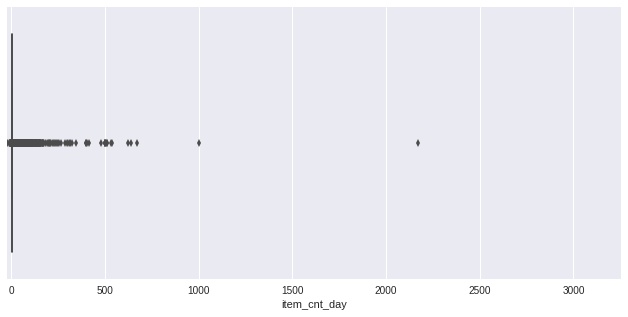

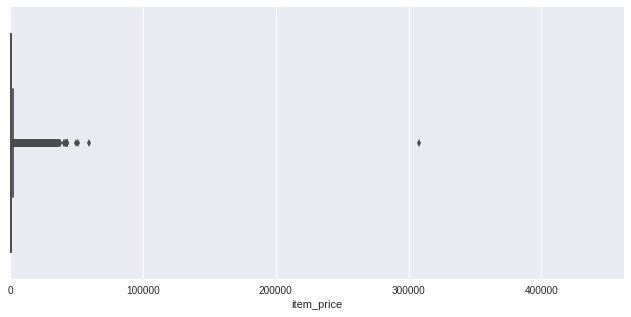

In [0]:

train_filtered = dataPreprocessing()


----------Random Forest--------------
{'bootstrap': 'False', 'max_features': 8, 'min_samples_leaf': 4, 'min_samples_split': 8, 'min_weight_fraction_leaf': 0.1, 'n_estimators': 20}
[0.30246109 0.1701387  0.1701387  ... 0.21368646 0.14232066 0.17717585]
                   0
count  214200.000000
mean        0.174912
std         0.052937
min         0.055021
25%         0.142321
50%         0.142321
75%         0.177093
max         0.378809

rmse score :
4.004550372615735

r1 score :
0.0009472468513301856

Explained variance score :
0.0009473533964928782

Mean absolute error :
0.30322722204656927

Median absolute error :
0.1597963338936275

---------Decision Tree--------------
[0.65102374 0.12501283 0.12501283 ... 0.12501283 0.12501283 0.12501283]
                   0
count  214200.000000
mean        0.234931
std         2.220584
min         0.000000
25%         0.125013
50%         0.125013
75%         0.125013
max       446.000000

rmse score :
1.1632481871941065

r1 score :
0.915700370

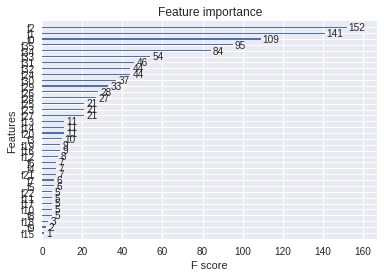

In [0]:
# returns the filtered x_test data
def getXtest():
  test_filtered = test_data[['shop_id', 'item_id']]
  test_filtered = test_filtered.merge(train_filtered, on = ["shop_id", "item_id"], how = "left").fillna(0.0)
  
  return test_filtered


# function to fit in xgboost model
def xgboost(x_train, y_train, x_test):
  
  param = {'max_depth':10, 
           'subsample':1,
           'min_child_weight':0.5,
           'eta':0.3, 
           'num_round':1000, 
           'seed':1,
           'silent':0,
           'eval_metric':'rmse'}

  xgbtrain = xgb.DMatrix(x_train, y_train)

  bst1 = xgb.train(param, xgbtrain)
  preds = bst1.predict(xgbtrain)
  
  xgb.plot_importance(bst1)
  
  y_test_pred = bst1.predict(xgb.DMatrix(x_test))
  print(y_test_pred)
  
  y_test_pred = list(map(lambda i: max(0, i), list(y_test_pred)))
  
  print(pd.DataFrame(y_test_pred).describe())
  
  return preds
  
  
###########################################  
# function to fit in xgbregressor model
###########################################
# Actual Tuned Parameters:
#     tuned_parameters = [
#       {
#           'nthread':[2, 4, 6], 
#           'objective':['reg:linear'],
#           'learning_rate': [.07, 0.01, 0.5], 
#           'max_depth': [3, 5, 7],
#           'min_child_weight': [2, 4, 8],
#           'silent': [0, 1],
#           'subsample': [0.5, 0.7, 1],
#           'colsample_bytree': [0.7, 1],
#           'n_estimators': [12, 20, 50],
#       }
#   ]
# Since it is taking very long time to process these parameters, we are tuning best parameters directly
def xgbregressor(xtrain, y_train, x_test):
    
  xgb_reg = XGBRegressor()
  parameters = {'nthread':[4], 
              'objective':['reg:linear'],
              'learning_rate': [.07], 
              'max_depth': [7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [12]}

  clf_xgbreg = GridSearchCV(xgb_reg,
                        parameters,
                        n_jobs = 5,
                        cv = 2,
                        verbose=True)

  clf_xgbreg.fit(x_train,y_train)
  
  #print(clf_xgbreg.best_params_)
  
  #values_to_predict = y_train
  preds = clf_RF.predict(x_train)
  
  y_test_pred = clf_xgbreg.predict(x_test)
  
  print(y_test_pred)
  
  print(pd.DataFrame(y_test_pred).describe())
  
  return preds


###########################################
# function to fit in randomForest model
###########################################
# Actual Tuned Parameters:
#     tuned_parameters = [
#       {
#           'max_features' : ['auto', 'sqrt', 'log2'],
#           'n_estimators': [20, 50, 60],
#           'min_weight_fraction_leaf' :[0.1, 1, 2],
#           'bootstrap' : ['True', 'False'],
#           'min_samples_split' : [2, 4, 8],
#           'min_samples_leaf': [1, 3, 4],
#           'max_features' : [2, 6, 8],
#       }
#   ]
# Since it is taking very long time to process these parameters, we are tuning best paramters directly
def randomForest(x_train, y_train, x_test):
  
  tuned_parameters = [
      {
          'max_features' : ['sqrt'],
          'n_estimators': [20],
          'min_weight_fraction_leaf' :[0.1],
          'bootstrap' : ['False'],
          'min_samples_split' : [8],
          'min_samples_leaf': [4],
          'max_features' : [8],
      }
  ]
  clf_RF = GridSearchCV(RandomForestRegressor(), tuned_parameters, scoring='neg_mean_squared_error', n_jobs = -1, cv=5)
  clf_RF.fit(x_train,y_train)
  print(clf_RF.best_params_)

  values_to_predict = y_train
  preds = clf_RF.predict(x_train)
  
  y_test_pred = clf_RF.predict(x_test)
  print(y_test_pred)
  print(pd.DataFrame(y_test_pred).describe())
  
  return preds


###########################################
# function to fit in adaBoost model
###########################################
# Actual Tuned Parameters:
#     tuned_parameters = [
#       {
#          'learning_rate' : [0.1, 0.5, 1],
#           'n_estimators': [20, 50, 60] ,
#           'loss' : ['linear', 'square', 'exponential'], 
#       }
#   ]
# Since it is taking very long time to process these parameters, we are tuning best paramters directly
def adaBoost(x_train, y_train, x_test):
  #AdaBoost Regressor - GridSearchCV
  
  tuned_parameters = [
      {
          'learning_rate' : [0.1],
          'n_estimators': [20] ,
          'loss' : ['linear'],  
      }
  ]
  clf_AB = GridSearchCV(AdaBoostRegressor(), tuned_parameters, scoring='neg_mean_squared_error', n_jobs = -1, cv=5)
  clf_AB.fit(x_train, y_train)
  print(clf_AB.best_params_)

  values_to_predict = y_train
  preds = clf_AB.predict(x_train)
  
  y_test_pred = clf_AB.predict(x_test)
  print(y_test_pred)
  print(pd.DataFrame(y_test_pred).describe())
  
  return preds

###########################################
# function to fit in bagging model
###########################################
# Actual Tuned Parameters:
#     tuned_parameters = [
#       {
#           'n_estimators': [50, 60, 100],
#           'max_samples' : [0.5, 1 , 2],
#           'bootstrap_features' : ['True', False'],
#           'bootstrap' : ['True', False'],
#           'max_features' : [1, 2 4],    
#       }
#   ]
# Since it is taking very long time to process these parameters, we are tuning best paramters directly
def bagging(x_train, y_train, x_test):
  #Bagging Regressor - GridSearchCV
  tuned_parameters = [
      {
          'n_estimators': [50],
          'max_samples' : [0.5],
          'bootstrap_features' : ['False'],
          'bootstrap' : ['False'],
          'max_features' : [1],    
      }
  ]
  clf_B = GridSearchCV(BaggingRegressor(), tuned_parameters, scoring='neg_mean_squared_error', n_jobs = -1, cv=5)
  clf_B.fit(x_train,y_train)
  print(clf_B.best_params_)

  values_to_predict = y_train
  preds = clf_B.predict(x_train)
  
  y_test_pred = clf_B.predict(x_test)
  print(y_test_pred)
  print(pd.DataFrame(y_test_pred).describe())
    
  return preds


###########################################
# function to fit in decision tree model
###########################################
# Actual Tuned Parameters:
#     tuned_parameters = [
#       {
#           'criterion' : ['mse'],
#           'splitter' : ['best', 'random'],
#           'max_depth' : [4, 8, 10],
#           'random_state' : [2, 10],  
#           'presort' : ['True', False'],
#           'max_features' : ['auto', 'sqrt', log2'],
#       }
#   ]
# Since it is taking very long time to process these parameters, we are tuning best paramters directly
def decisionTree(x_train, y_train, x_test):
  tuned_parameters = [
      {
          'criterion' : ['mse'],
          'splitter' : ['best'],
          'max_depth' : [10],
          'random_state' : [2],  
          'presort' : ['False'],
          'max_features' : ['log2'],
      }
  ]

  clf_dtreereg = GridSearchCV(DecisionTreeRegressor(), tuned_parameters, scoring='neg_mean_squared_error', n_jobs = -1, cv=5)
  # clf_dtreereg = tree.DecisionTreeRegressor(criterion = 'mse', splitter='best', max_depth = 10, random_state = 2, presort = False, max_features = "log2")
  #log2 gives the best result. So does auto.
  clf_dtreereg.fit(x_train, y_train)

  values_to_predict = y_train;

  predictions = clf_dtreereg.predict(x_train) #This is our prediction.
  
  y_test_pred = clf_dtreereg.predict(x_test)
  print(y_test_pred)
  print(pd.DataFrame(y_test_pred).describe())
  
  return predictions


# function to display error metrics for the respective model
def errorMetrics(y_train, preds):
  #Calculating rmse score
  rmse = np.sqrt(mean_squared_error(y_train, preds))
  print('\nrmse score :')
  print(rmse)
  
  #Calculating R2 Score
  print('\nr1 score :')
  print(r2_score(y_train, preds, multioutput='variance_weighted'))

  #Calculating explained variance score
  
  print('\nExplained variance score :')
  print(explained_variance_score(y_train, preds, multioutput='uniform_average'))

  #Calculating mean absolute error
  
  print('\nMean absolute error :')
  print(mean_absolute_error(y_train, preds))

  #Calculating mean squared log error
  #from sklearn.metrics import mean_squared_log_error
  #print('Mean squared log error')
  #print(mean_squared_log_error(flat_list, preds))

  #Calculating median absolute error
  
  print('\nMedian absolute error :')
  print(median_absolute_error(y_train, preds))


# function to call respective models to fit the data
def models(x_train, y_train, x_test):
  
  print('\n----------Random Forest--------------')
  errorMetrics(y_train, randomForest(x_train, y_train, x_test))
  print('\n---------Decision Tree--------------')
  errorMetrics(y_train, decisionTree(x_train, y_train, x_test))
  print('\n----------AdaBoost--------------')
  errorMetrics(y_train, adaBoost(x_train, y_train, x_test))
  print('\n----------Bagging--------------')
  errorMetrics(y_train, bagging(x_train, y_train, x_test))
  print('\n-------- XG-BOOST ---------')
  errorMetrics(y_train, xgboost(x_train, y_train, x_test))


test_filtered = getXtest()
x_test = test_filtered.iloc[:, test_filtered.columns != 0].values
x_train = train_filtered.iloc[:,  (train_filtered.columns != 33)].values
y_train = train_filtered.iloc[:, train_filtered.columns == 33].values

models(x_train , y_train, x_test)


